In [1]:
import random

import hydra
import numpy as np
import torch
import torch.nn.functional as F
from diffusers import AutoencoderKL, DDIMScheduler
from diffusers.optimization import get_scheduler
from diffusers.utils.import_utils import is_xformers_available
from einops import rearrange
from peft import LoraConfig, get_peft_model
from transformers import CLIPTextModel, CLIPTokenizer

from im2flow2act.flow_generation.animatediff.models.unet import UNet3DConditionModel
from im2flow2act.flow_generation.AnimateFlow import AnimateFlow
from im2flow2act.flow_generation.AnimationFlowPipeline import AnimationFlowPipeline
from im2flow2act.flow_generation.inference import inference_from_dataset

In [2]:
from hydra import initialize, compose
from omegaconf import DictConfig

In [3]:
device = "cuda:0"
import os
dev_dir = os.environ['DEV_PATH']
dev_dir
print(torch.cuda.device_count())

1


In [4]:
with initialize(config_path="../config/flow_generation", version_base=None):
    cfg: DictConfig = compose(config_name="inference")

from im2flow2act.flow_generation.inference import (
    inference,
    load_model,
    load_config
)
vae, text_encoder, tokenizer, noise_scheduler, flow_generator = load_model(cfg)

loading vae from /home/yuanhong/Documents/im2Flow2Act/im2flow2act/checkpoints/decoder/checkpoints/epoch_400
loading tokenizer and text_encoder from /home/yuanhong/Documents/im2Flow2Act/im2flow2act/pretrain_weights/StableDiffusion1.5
loading unet from /home/yuanhong/Documents/im2Flow2Act/im2flow2act/pretrain_weights/StableDiffusion1.5
loaded 3D unet's pretrained weights from /home/yuanhong/Documents/im2Flow2Act/im2flow2act/pretrain_weights/StableDiffusion1.5/unet ...
### missing keys: 560; 
### unexpected keys: 0;
### Motion Module Parameters: 417.1376 M
Loading complete model...
>> loaded model


In [5]:
flow_generator.__class__

im2flow2act.flow_generation.AnimateFlow.AnimateFlow

In [6]:
# Load all the necessary model during inference
with initialize(config_path="../config/flow_generation", version_base=None):
    cfg: DictConfig = compose(config_name="train_flow_generation")

vae_pretrained_model_path = f"{dev_dir}/checkpoints/decoder/checkpoints/epoch_400"
unet_pretrained_model_path = f"{dev_dir}/checkpoints/flow_generation/"

vae_t = AutoencoderKL.from_pretrained(vae_pretrained_model_path)
tokenizer = CLIPTokenizer.from_pretrained(
    cfg.pretrained_model_path, subfolder="tokenizer"
)
text_encoder_t = CLIPTextModel.from_pretrained(
    cfg.pretrained_model_path, subfolder="text_encoder"
)
unet_t = UNet3DConditionModel.from_pretrained_2d(
    cfg.pretrained_model_path,
    subfolder="unet",
    unet_additional_kwargs=cfg.unet_additional_kwargs,
)

noise_scheduler_t = DDIMScheduler(**cfg.noise_scheduler_kwargs)

vae_t.requires_grad_(False)
text_encoder_t.requires_grad_(False)
unet_t.requires_grad_(False)

unet_t.to(device)
vae_t.to(device)
text_encoder_t.to(device)

flow_generator_t = AnimateFlow(unet=unet_t, **cfg.animateflow_kwargs)

flow_generator_t.load_model(
    f"{dev_dir}/checkpoints/flow_generation/checkpoints/epoch_1800/epoch_1800.ckpt"
)

loaded 3D unet's pretrained weights from /home/yuanhong/Documents/im2Flow2Act/im2flow2act/pretrain_weights/StableDiffusion1.5/unet ...
### missing keys: 560; 
### unexpected keys: 0;
### Motion Module Parameters: 417.1376 M
Loading complete model...
>> loaded model


In [7]:
cfg.animateflow_kwargs

{'clip_model': 'openai/clip-vit-large-patch14', 'global_image_size': [224, 224], 'freeze_visual_encoder': True, 'global_condition_type': 'all', 'emb_dim': 768}

In [8]:
# load the dataset
dataset = hydra.utils.instantiate(cfg.dataset)

>> max_episode [None, None, None]


Loading /home/yuanhong/Documents/im2Flow2Act/im2flow2act/data/simulation_sphere_demonstration/pickNplace: 100%|█| 10


>> Loaded 1000 data from /home/yuanhong/Documents/im2Flow2Act/im2flow2act/data/simulation_sphere_demonstration/pickNplace


Loading /home/yuanhong/Documents/im2Flow2Act/im2flow2act/data/simulation_sphere_demonstration/pouring: 100%|█| 800/8


>> Loaded 800 data from /home/yuanhong/Documents/im2Flow2Act/im2flow2act/data/simulation_sphere_demonstration/pouring


Loading /home/yuanhong/Documents/im2Flow2Act/im2flow2act/data/simulation_sphere_demonstration/drawer_open: 100%|█| 1

>> Loaded 1100 data from /home/yuanhong/Documents/im2Flow2Act/im2flow2act/data/simulation_sphere_demonstration/drawer_open


In [9]:
dataset.__class__

im2flow2act.flow_generation.dataloader.animateflow_dataset.AnimateFlowDataset

In [10]:
sample = dataset.train_data[1500]
sample.keys()

dict_keys(['global_image', 'point_tracking_sequence', 'first_frame_point_uv', 'text'])

In [11]:
dataset.train_data[0]["first_frame_point_uv"]

array([[ 90,  74],
       [ 91,  74],
       [ 92,  74],
       ...,
       [109, 126],
       [110, 126],
       [111, 126]])

In [12]:
sample["global_image"].__class__

numpy.ndarray

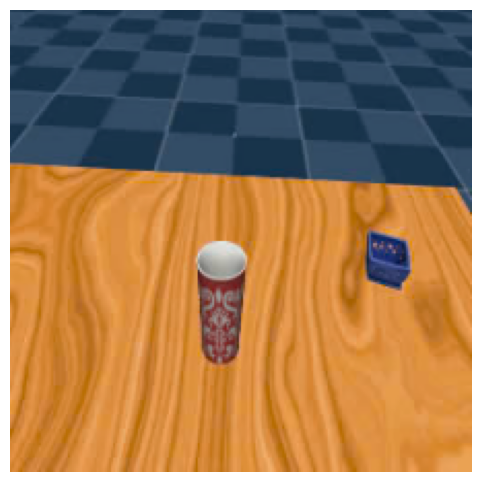

Pour water from the mug to the blue bowl.


In [13]:
import matplotlib.pyplot as plt
import numpy as np

global_image = sample["global_image"]

plt.figure(figsize=(6,6))
plt.imshow(global_image.astype(np.uint8))
plt.axis("off")
plt.show()
prompt = sample["text"]
print(sample["text"])

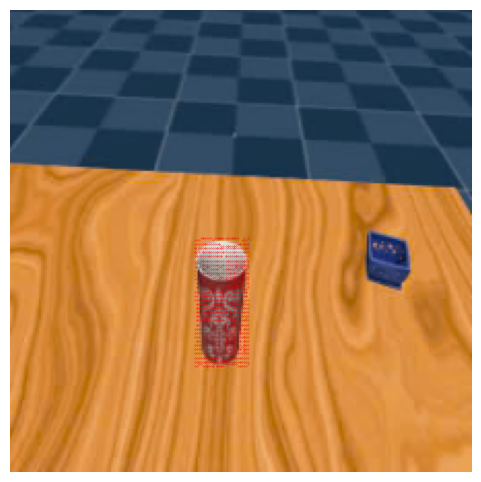

In [14]:
points = sample["first_frame_point_uv"]

plt.figure(figsize=(6,6))
plt.scatter(points[:, 0], points[:, 1], color="red", s=0.1, alpha=0.6)
plt.imshow(global_image.astype(np.uint8))
plt.axis("off")
plt.show()

In [15]:
point_tracking_sequence = sample["point_tracking_sequence"]
point_tracking_sequence.shape

(32, 3, 32, 32)

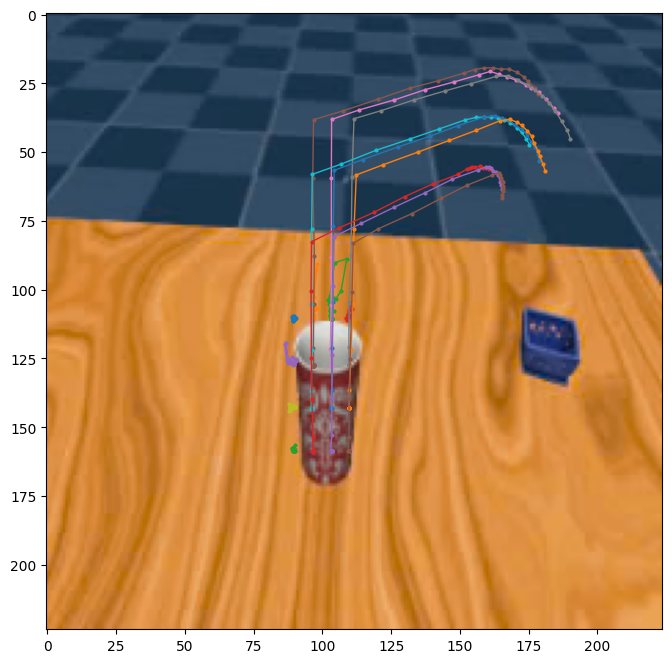

In [16]:
T, coord_dim, grid_h, grid_w = point_tracking_sequence.shape
H, W, _ = global_image.shape

plt.figure(figsize=(8, 8))
plt.imshow(global_image)

for i in range(0, grid_h, 8):
    for j in range(0, grid_w, 8):
        trajectory = point_tracking_sequence[:, :, i, j]
    
        plt.plot(trajectory[:, 0]*W, trajectory[:, 1] * H,
                 marker='o', markersize=2, linewidth=1)

In [17]:
global_image_torch = torch.tensor(np.copy(global_image))
points_torch = torch.tensor(np.copy(points))

In [23]:
from einops import rearrange

flow_generator.to(device)

pipeline = AnimationFlowPipeline(
    vae=vae_t,
    text_encoder=text_encoder_t,
    tokenizer=tokenizer,
    model=flow_generator_t.to(device),
    scheduler=noise_scheduler,
)

num_inference_steps = 50
guidance_scale = 7.5

video_length = sample["point_tracking_sequence"].shape[0]

outputs = pipeline(
    prompt=prompt,
    global_image=rearrange(global_image_torch, "h w c -> 1 c h w"),
    point_uv=rearrange(points_torch, "n c -> 1 n c"),
    video_length=video_length,
    num_inference_steps=40,
    guidance_scale=7.5,
    height=dataset.grid_size,
    width=dataset.grid_size,
    output_type="numpy"
)

40it [10:29, 15.74s/it]
100%|██████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 177.38it/s]


In [ ]:
T, coord_dim, grid_h, grid_w = outputs[0].shape

plt.figure(figsize=(8, 8))
plt.imshow(global_image)

for i in range(0, grid_h, 8):
    for j in range(0, grid_w, 8):
        trajectory = outputs[0][:, :, i, j]
    
        plt.plot(trajectory[:, 0]*H, trajectory[:, 1]*W,
                 marker='o', markersize=2, linewidth=1)

In [ ]:
# Hmm seems it's the problem with the encoder that I'm loading
# This is the unet that works that was loaded from 
with initialize(config_path="../config/flow_generation", version_base=None):
    cfg: DictConfig = compose(config_name="inference")

model_cfg = load_config(cfg.model_path)
print(model_cfg.pretrained_model_path)
print(model_cfg.unet_additional_kwargs)

In [ ]:
with initialize(config_path="../config/flow_generation", version_base=None):
    cfg: DictConfig = compose(config_name="train_flow_generation")

print(cfg.pretrained_model_path)
print(cfg.unet_additional_kwargs)